<a href="https://colab.research.google.com/github/codeskavy/Virtual_Tryon/blob/main/Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision Pillow matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

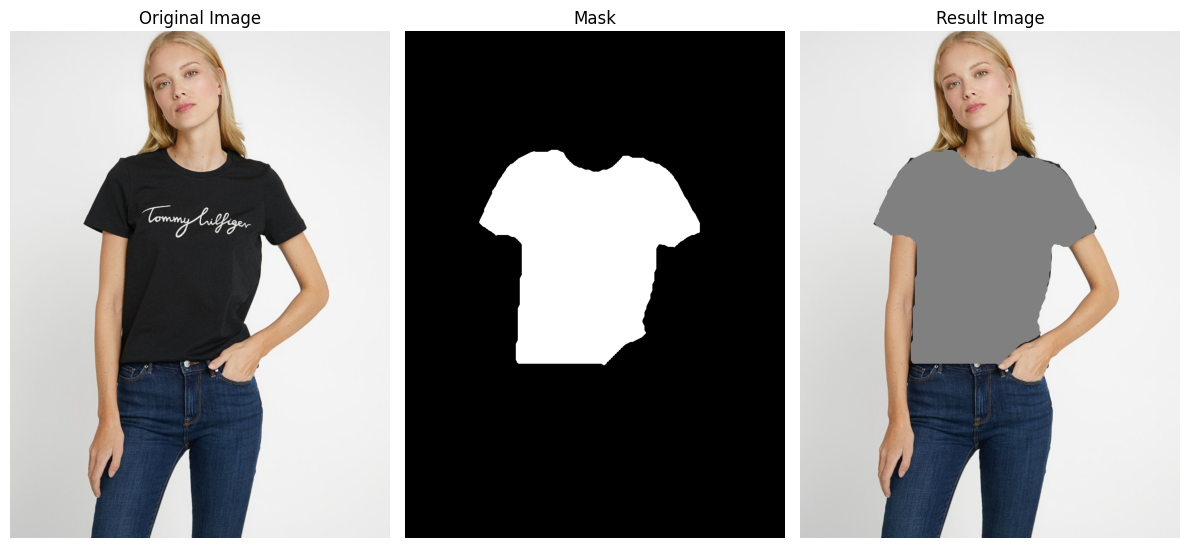

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the images
original_image = cv2.imread('/content/00046_00 2.jpg')
mask_image = cv2.imread('/content/00046_00.jpg', cv2.IMREAD_GRAYSCALE)  # Ensure the mask is in grayscale

# Convert the original image to RGB
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Apply threshold to create a binary mask
_, mask = cv2.threshold(mask_image, 127, 255, cv2.THRESH_BINARY)

# Create a grey image
grey_image = np.ones_like(original_image) * 128  # 128 for grey

# Apply the mask to the grey image and the inverse mask to the original image
masked_grey = cv2.bitwise_and(grey_image, grey_image, mask=mask)
masked_original = cv2.bitwise_and(original_image, original_image, mask=cv2.bitwise_not(mask))

# Combine the masked images
result_image = cv2.add(masked_grey, masked_original)

# Convert the result image to RGB
result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(original_image_rgb)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Result Image')
plt.imshow(result_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

# Store the result image in a variable
final_result_image = result_image_rgb


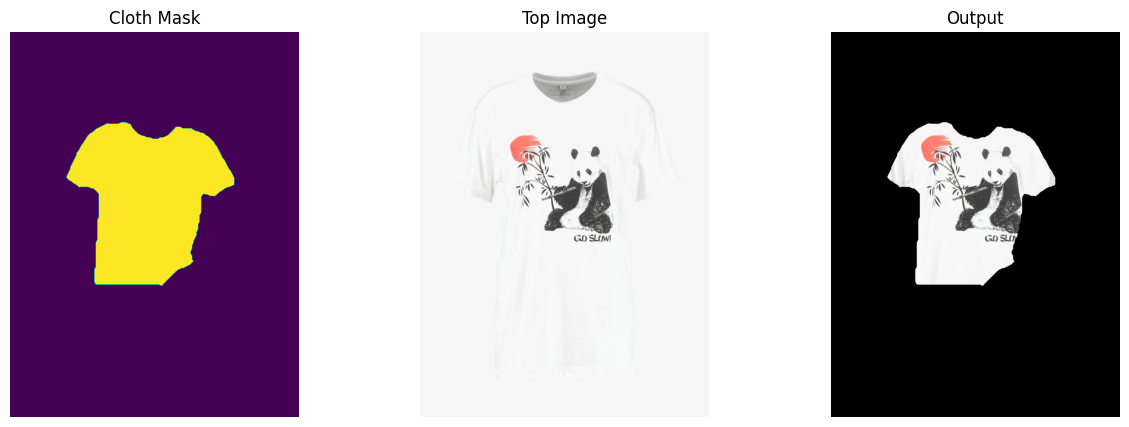

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    original_size = image.size
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0), original_size

# Paths to the images
cloth_mask_path = '/content/00046_00.jpg'
top_image_path = '/content/00124_00.jpg'

# Preprocess the images
cloth_mask, cloth_mask_size = preprocess_image(cloth_mask_path)
top_image, top_image_size = preprocess_image(top_image_path)

# Resize cloth mask if necessary
if cloth_mask_size != top_image_size:
    cloth_mask = F.interpolate(cloth_mask, size=top_image_size[::-1], mode='bilinear', align_corners=False)

# Perform the operation and store the result in a variable
output = top_image * cloth_mask

# Convert the result to an image for display
output_image = transforms.ToPILImage()(output.squeeze())

# Store the result in a variable for later use
result_image = output_image

# Display the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(Image.open(cloth_mask_path))
ax[0].set_title('Cloth Mask')
ax[0].axis('off')

ax[1].imshow(Image.open(top_image_path))
ax[1].set_title('Top Image')
ax[1].axis('off')

ax[2].imshow(output_image)
ax[2].set_title('Output')
ax[2].axis('off')

plt.show()

# The result_image variable can be used later in your code


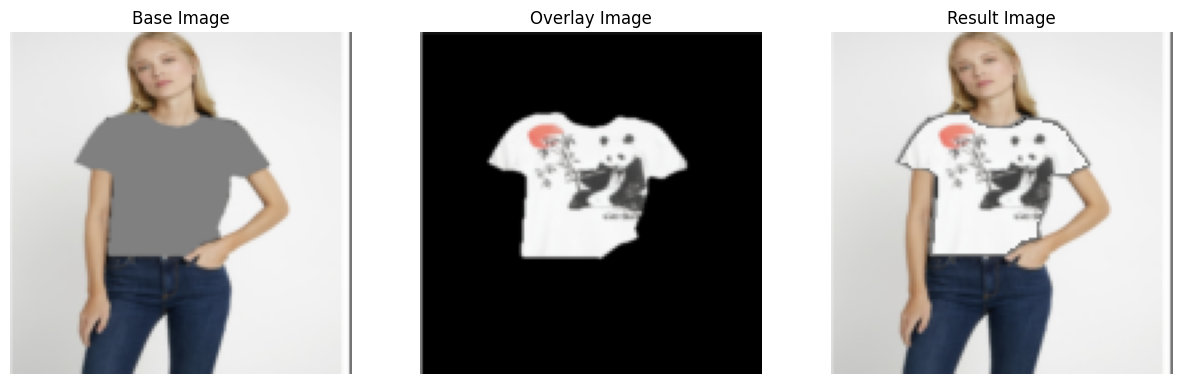

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load and preprocess images
def preprocess_image(image_path, size=(128, 128)):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Define a mask for regions to overlay
def create_mask(image, region_color=(128, 128, 128)):
    image_np = np.array(image)
    mask = np.all(image_np == region_color, axis=-1)
    mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0).repeat(3, 1, 1)
    return mask

# Overlay second image onto the first image using the mask
def apply_mask(base_image, overlay_image, mask):
    # Ensure mask is applied to the same size as images
    if base_image.size() != mask.size():
        mask = F.interpolate(mask.unsqueeze(0), size=base_image.shape[2:], mode='bilinear', align_corners=False).squeeze(0)

    # Apply mask
    masked_overlay = overlay_image * mask
    result_image = base_image * (1 - mask) + masked_overlay
    return result_image

# Paths to images
base_image_path = '/content/Screenshot 2024-07-31 at 5.28.46 AM.png'
overlay_image_path = '/content/Screenshot 2024-07-31 at 5.29.04 AM.png'

# Load and preprocess images
base_image = preprocess_image(base_image_path)
overlay_image = preprocess_image(overlay_image_path)

# Create mask using the base image to define regions
base_image_pil = transforms.ToPILImage()(base_image.squeeze(0))  # Convert tensor to PIL for mask creation
mask = create_mask(base_image_pil, region_color=(128, 128, 128))  # Adjust the region_color if needed


result_image = apply_mask(base_image, overlay_image, mask)


def tensor_to_image(tensor):
    return transforms.ToPILImage()(tensor.squeeze(0))


plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(tensor_to_image(base_image))
plt.title('Base Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tensor_to_image(overlay_image))
plt.title('Overlay Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tensor_to_image(result_image))
plt.title('Result Image')
plt.axis('off')

plt.show()